# Network Response for Random Inflows

Random flows generated for emperical and GP estimate of uncertainity

In [1]:
import baestorm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyswmm_lite import environment

## Stormwater Network : Single Basin

In [3]:
def single_basin(actions, flows):
    env = environment(baestorm.load_networks("parallel"), False)
    data = {}
    data["outflow"] = []
    data["overflow"] = []
    data["depth"] = []
    # pad inflows, so that the systems receds
    flows = np.append(flows, np.zeros(300))
    for time in range(0, len(flows)):
        # set the gate_position
        env._setValvePosition("1", actions)
        # set inflow
        env.sim._model.setNodeInflow("P1", 3 * flows[time])
        env.sim._model.setNodeInflow("P2", 0.0)
        # record_data
        data["outflow"].append(env._getLinkFlow("1"))
        data["overflow"].append(env.sim._model.getNodeResult("P1", 4))
        data["depth"].append(env._getNodeDepth("P1"))
        # step through simulation
        _ = env.step()
    env._terminate()
    return data["outflow"], sum(data["overflow"]), data["depth"]

## Random Inflows

Inflow are generated using Gaussian Distribution. Mean controls when peaks is achived and Variance controls the dispersion of the inflows. Given that this approach to control looks at the entire response, time of peak is pointless. Hence, we only vary dispersion and scale. 

In [4]:
def gaussian_flows(x, mu=0.0, sigma=1.0):
    y = (1.0/(sigma*(np.sqrt(2.0*np.pi)))) * np.exp(-0.5*((x-mu)/sigma)**2)
    return y

In [17]:
gaussian_flows = np.vectorize(gaussian_flows)
sigma = np.linspace(1.0, 7.0, 10)
scale = 10.0

inflows = {}
for idx, sig in enumerate(sigma):
    inflows[str(idx)] = scale * gaussian_flows(np.linspace(-10.0, 10.0, 100), sigma=sig)

inflows = pd.DataFrame.from_dict(inflows)

Text(0.5, 0, 'TimeSteps')

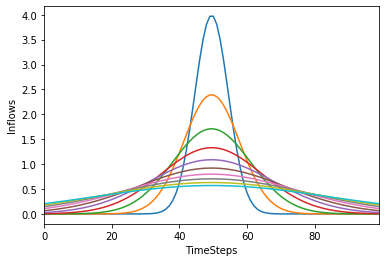

In [18]:
ax = inflows.plot(legend=False)
ax.set_ylabel("Inflows")
ax.set_xlabel("TimeSteps")

## System's response

In [19]:
data_flows = {}
for i in inflows.keys():
    flows, overflow, depth  = single_basin(1.0, inflows[i].values)
    data_flows[i] = flows
data_flows = pd.DataFrame.from_dict(data_flows)

Text(0, 0.5, 'Outflow')

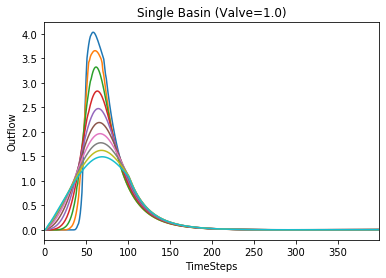

In [20]:
ax = data_flows.plot(legend=False, title="Single Basin (Valve=1.0)")
ax.set_xlabel("TimeSteps")
ax.set_ylabel("Outflow")

### Evaluate Responses

Discretize actions to 1% opening and log its response for all possible events.

In [33]:
actions = np.linspace(0, 1.0, 100) # 100 actions 
events = inflows.keys() # 10 events 
responses = {}

for idx,act in enumerate(actions):
    for event in events:
        flows, overflow, depth = single_basin(act, inflows[event])
        responses[str(idx)+event]={'flows':flows,
                                   'overflow':overflow,
                                   'depth':depth}

In [37]:
np.save('Responses', responses)